# Project Stage II

## By Mostafa Abdelmegeed

#### Importing Modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set_style('darkgrid')

#### Setting Constants

This can be used to change parameters of the analysis, to spit out a whole different analysis

In [3]:
CONFIRMED_CASES_DATASET_PATH = 'data/covid_confirmed_usafacts.csv'
DEATHS_DATASET_PATH = 'data/covid_deaths_usafacts.csv'
POPULATION_DATASET_PATH = 'data/covid_county_population_usafacts.csv'
START_YEAR = 2022
START_MONTH = 5
START_DAY = 31
END_YEAR = 2022
END_MONTH = 12
END_DAY = 31
LOWER_INTERVAL_BOUND = dt.datetime(START_YEAR, START_MONTH, START_DAY)  # Datetime object from which the analysis on the data starts
UPPER_INTERVAL_BOUND = dt.datetime(END_YEAR, END_MONTH, END_DAY)        # Datetime object from which the analysis on the data ends
STATES = ['CA', 'NV', 'NM', 'NJ']   # States of Interest
NORMALIZATION_FACTOR = 1000000      # Normalization factor used

#### Implemented Methods for reusability and modularity

In [4]:
def get_df_from_to(df, start_date=LOWER_INTERVAL_BOUND, end_date=UPPER_INTERVAL_BOUND):
    """ 
    A method to return a snipped time interval from a bigger dataframe
    Args:
        df (Pandas.DataFrame): Dataframe with columns as datetime
        start_date (Datetime, optional): Defaults to LOWER_INTERVAL_BOUND.
        end_date (Datetime, optional): Defaults to UPPER_INTERVAL_BOUND.

    Returns:
        DataFrame
    """
    f = lambda col: col if dt.datetime.strptime(col, '%Y-%m-%d') <= end_date and dt.datetime.strptime(col, '%Y-%m-%d') >= start_date else None
    covid_recent_cols = [col for col in df.columns[:4]]
    covid_recent_cols += ([f(col) for col in df.columns[5:]])
    covid_from_to = []
    for col in covid_recent_cols:
        if col is not None:
            covid_from_to.append(col)
    return df[covid_from_to]

def normalize(df, pop, nf=NORMALIZATION_FACTOR):
    """
    Returns a normalized version of the dataframe

    Args:
        df (Dataframe):
        pop (int): Population of the selected jurisdiction
        nf (int, optional): Normalization Factor. Defaults to NORMALIZATION_FACTOR.

    Returns:
        Dataframe:
    """
    return (df/pop) * nf

def get_weekly_statistics(df, statistic='mean'):
    """
    Returns a specific statistic from the input dataframe
    Args:
        df (Dataframe):
        statistic (str, optional): Defaults to 'mean'.

    Returns:
        Dataframe:
    """
    if statistic == 'mode':
        return df.groupby(df.index.isocalendar().week, axis=0).agg(lambda entry: entry.mode().to_numpy()[-1])
    elif statistic == 'median':
        return df.groupby(df.index.isocalendar().week, axis=0).median()
    elif statistic == 'mean':
        return df.groupby(df.index.isocalendar().week, axis=0).mean()
    else:
        return df.groupby(df.index.isocalendar().week, axis=0).sum()

def get_state_population(state):
    """
    Returns the population of the selected state

    Args:
        state (str): State abb

    Returns:
        int: Population
    """
    population = pd.read_csv(POPULATION_DATASET_PATH)
    population = population.groupby('State').sum(numeric_only=True)
    return population.loc[state, 'population']

def get_county_population(state, countyFIPS):
    """
    Returns the input county population

    Args:
        state (str): State abb
        countyFIPS (int):

    Returns:
        int: Population
    """
    population = pd.read_csv(POPULATION_DATASET_PATH)
    return population[(population['State'] == state) & (population['countyFIPS'] == countyFIPS)]['population'].values[0]

def get_county_name_by_fips(fips):
    """
    Returns County Name for the input countyFIPS
    Args:
        fips (int):

    Returns:
        str: County Name
    """
    population = pd.read_csv(POPULATION_DATASET_PATH)
    return population[(population['countyFIPS'] == fips)]['County Name'].iloc[0]

def get_us_new_cases_and_deaths():
    """
    Returns a dataframe of the cases and deaths in the US

    Returns:
        Dataframe:
    """
    us_covid_cases_df = get_df_from_to(pd.read_csv(CONFIRMED_CASES_DATASET_PATH))
    us_covid_deaths_df = get_df_from_to(pd.read_csv(DEATHS_DATASET_PATH))
    us_covid_cases_df = us_covid_cases_df[us_covid_cases_df['countyFIPS'] != 0]
    us_covid_deaths_df = us_covid_deaths_df[us_covid_deaths_df['countyFIPS'] != 0]
    us_covid_cases_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_deaths_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_cases_df = us_covid_cases_df.agg(np.sum, axis=0)
    us_covid_deaths_df = us_covid_deaths_df.agg(np.sum, axis=0)
    us_covid_time_series_df = pd.concat([us_covid_cases_df, us_covid_deaths_df], axis=1).diff(axis=0)
    us_covid_time_series_df.drop(us_covid_time_series_df.index[0], inplace=True)
    us_covid_time_series_df.columns = ['Cases', 'Deaths']
    us_covid_time_series_df.index = pd.to_datetime(us_covid_time_series_df.index)
    return us_covid_time_series_df

    
def get_state_new_cases_and_deaths(state):
    """
    Returns a dataframe of the new covid cases and deaths for the selected state
    Args:
        state (str):

    Returns:
        Dataframe:
    """
    covid_cases_df = pd.read_csv(CONFIRMED_CASES_DATASET_PATH)
    covid_deaths_df = pd.read_csv(DEATHS_DATASET_PATH)
    covid_cases_df = covid_cases_df[covid_cases_df['countyFIPS'] != 0]
    covid_deaths_df = covid_deaths_df[covid_deaths_df['countyFIPS'] != 0]
    covid_cases_df = get_df_from_to(covid_cases_df).drop_duplicates()
    covid_deaths_df = get_df_from_to(covid_deaths_df).drop_duplicates()
    covid_cases_ca_df = covid_cases_df.groupby('State').sum(numeric_only=True).drop(['countyFIPS', 'StateFIPS'], axis=1).reset_index()
    covid_cases_ca_df = covid_cases_ca_df[covid_cases_ca_df['State'] == state].set_index('State')
    covid_deaths_ca_df = covid_deaths_df.groupby('State').sum(numeric_only=True).drop(['countyFIPS', 'StateFIPS'], axis=1).reset_index()
    covid_deaths_ca_df = covid_deaths_ca_df[covid_deaths_ca_df['State'] == state].set_index('State')
    covid_cases_ca_weekly_df = covid_cases_ca_df.reset_index().drop('State', axis=1)
    covid_deaths_ca_weekly_df = covid_deaths_ca_df.reset_index().drop('State', axis=1)
    covid_cases_ca_weekly_df.columns = pd.to_datetime(covid_cases_ca_weekly_df.columns)
    covid_deaths_ca_weekly_df.columns = pd.to_datetime(covid_deaths_ca_weekly_df.columns)
    covid_cases_ca_weekly_df = covid_cases_ca_weekly_df.transpose()
    covid_deaths_ca_weekly_df = covid_deaths_ca_weekly_df.transpose()
    covid_deaths_ca_weekly_df.columns = ['Deaths']
    covid_deaths_ca_weekly_df['Deaths'] = covid_deaths_ca_weekly_df['Deaths'].diff().fillna(covid_deaths_ca_weekly_df['Deaths'])
    covid_cases_ca_weekly_df.columns = ['Cases']
    covid_cases_ca_weekly_df['Cases'] = covid_cases_ca_weekly_df['Cases'].diff().fillna(covid_cases_ca_weekly_df['Cases'])
    covid_time_series = pd.concat([covid_cases_ca_weekly_df, covid_deaths_ca_weekly_df], axis=1).round().astype(int)
    covid_time_series.drop(covid_time_series.index[0], inplace=True)
    return covid_time_series

#### First Requirement

##### Generate weekly statistics (mean, median, mode) for number of new cases and deaths across a specific state.

Initial Selected State is California, but this can change by changing the STATES list in the constants section at the beginning of this notebook

In [5]:
state_1_covid_df = get_state_new_cases_and_deaths(STATES[0])    # A dataframe of the state's new cases and deaths as columns, and datetime as index
covid_time_series_mode = get_weekly_statistics(state_1_covid_df, 'mode').round()
covid_time_series_median = get_weekly_statistics(state_1_covid_df, 'median').round()
covid_time_series_mean = get_weekly_statistics(state_1_covid_df, 'mean').round()
state_1_covid_df.to_csv('data/'+STATES[0]+'_data.csv')

Plotting the results

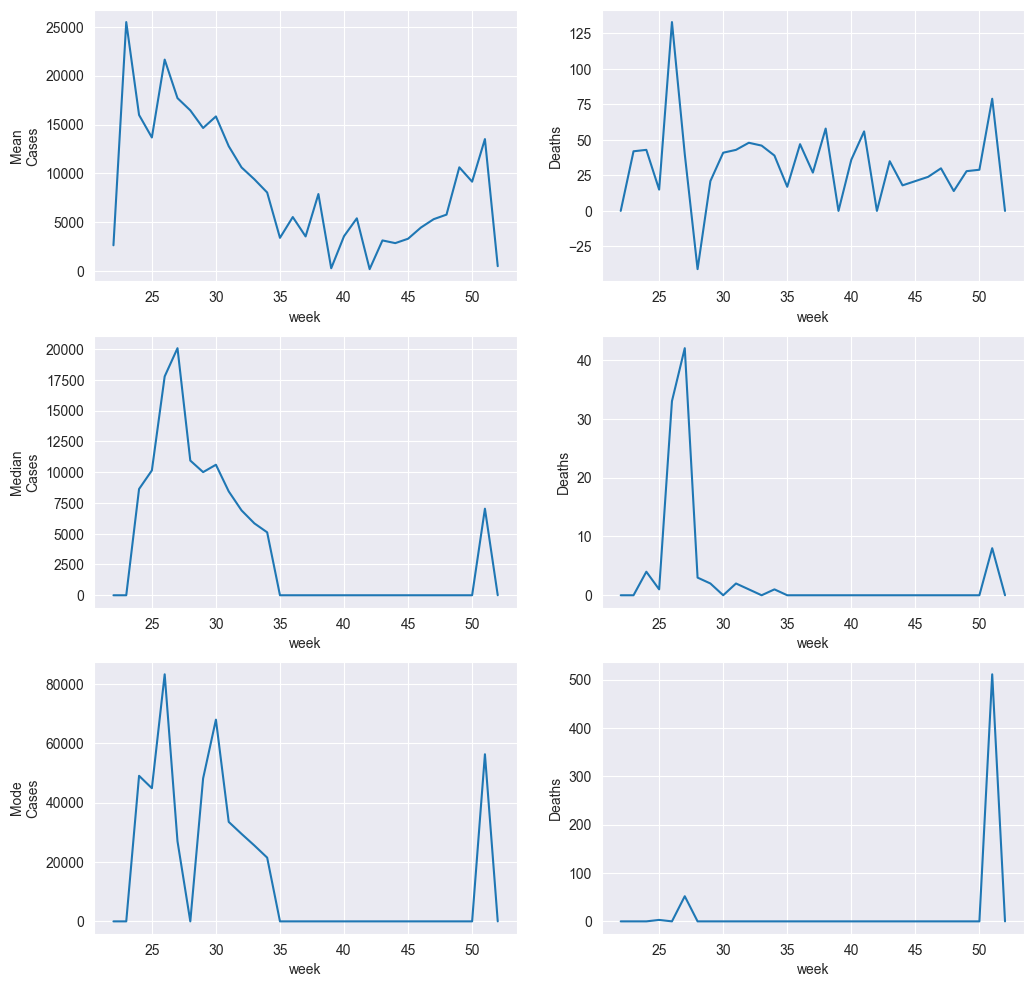

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].set_ylabel('Mean\nCases')
ax[1, 0].set_ylabel('Median\nCases')
ax[2, 0].set_ylabel('Mode\nCases')
sns.lineplot(data=covid_time_series_mean['Cases'], ax=ax[0,0])
sns.lineplot(data=covid_time_series_mean['Deaths'], ax=ax[0,1])
sns.lineplot(data=covid_time_series_median['Cases'], ax=ax[1,0])
sns.lineplot(data=covid_time_series_median['Deaths'], ax=ax[1,1])
sns.lineplot(data=covid_time_series_mode['Cases'], ax=ax[2,0])
plot = sns.lineplot(data=covid_time_series_mode['Deaths'], ax=ax[2,1])


What has been noticed, is there are negative Deaths values that appear here and there, this is propably an error due to data entry human errors, however, it can be ignored here and still get a sense of the data trend

##### Population Extracting

In [7]:
pop_df = pd.read_csv(POPULATION_DATASET_PATH)
pop_df = pop_df[pop_df['countyFIPS'] != 0]
pop_state_df = pop_df.drop(['countyFIPS', 'County Name'], axis=1).groupby('State').sum()

### Second Requirement
#### Compare the data against 3 other states. Normalize by population, use a normalization factor which is able to identify cases and deaths, for example try per 10,000 or 100,000 (this depends on the population). Plot the values across the weeks in a line plot for the 3 states in a single graph. Describe why the rates differ across these states in the notebook. Identify the peaks, are they consistent with the US pattern?

The following cell contains the wrangling and preparation of the data from different states, first we normalize the numbers using the normalization factor of 1000000, and the population of each state.

The Normalization Factor can be changed from the constants section at the beginning of this notebook.

After normalizing the cases and deaths of every state, the dataframes are concatenated into one whole dataframe, with the states abb names as keys.

Finally, the data is grouped by the week, and the different statistics are calculated, and rounded. Sum, Mean, Median, and Mode are calculated and put into their separate dataframes for easier plotting.

The states of interest are Nevada, New Mexico, and New Jersey, but those can be changed simply by changing the state abb name in the STATES array at the constants section at the beginning of this notebook

In [8]:
state_1_covid_df = get_state_new_cases_and_deaths(STATES[0])
state_2_covid_df = get_state_new_cases_and_deaths(STATES[1])
state_3_covid_df = get_state_new_cases_and_deaths(STATES[2])
state_4_covid_df = get_state_new_cases_and_deaths(STATES[3])
state_1_covid_df['Population'] = get_state_population(STATES[0])
state_2_covid_df['Population'] = get_state_population(STATES[1])
state_3_covid_df['Population'] = get_state_population(STATES[2])
state_4_covid_df['Population'] = get_state_population(STATES[3])
state_1_covid_df.to_csv('data/{}_new_cases_deaths.csv'.format(STATES[0]))
state_2_covid_df.to_csv('data/{}_new_cases_deaths.csv'.format(STATES[1]))
state_3_covid_df.to_csv('data/{}_new_cases_deaths.csv'.format(STATES[2]))
state_4_covid_df.to_csv('data/{}_new_cases_deaths.csv'.format(STATES[3]))

In [9]:
state_1_covid_df = normalize(state_1_covid_df, pop_state_df.loc[STATES[0]]['population'], NORMALIZATION_FACTOR).round()
state_2_covid_df = normalize(get_state_new_cases_and_deaths(STATES[1]), pop_state_df.loc[STATES[1]]['population'], NORMALIZATION_FACTOR).round()
state_3_covid_df = normalize(get_state_new_cases_and_deaths(STATES[2]), pop_state_df.loc[STATES[2]]['population'], NORMALIZATION_FACTOR).round()
state_4_covid_df = normalize(get_state_new_cases_and_deaths(STATES[3]), pop_state_df.loc[STATES[3]]['population'], NORMALIZATION_FACTOR).round()
states_covid_cases_normalized_df = pd.concat([state_2_covid_df['Cases'], state_3_covid_df['Cases'], state_4_covid_df['Cases']], axis=1, keys=STATES[1:])
states_covid_deaths_normalized_df = pd.concat([state_2_covid_df['Deaths'], state_3_covid_df['Deaths'], state_4_covid_df['Deaths']], axis=1, keys=STATES[1:])
states_covid_cases_time_series_weekly_sum_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).sum()
states_covid_deaths_time_series_weekly_sum_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).sum()
states_covid_cases_time_series_weekly_mean_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).mean().round()
states_covid_deaths_time_series_weekly_mean_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).mean().round()
states_covid_cases_time_series_weekly_median_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).median().round()
states_covid_deaths_time_series_weekly_median_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).median().round()
states_covid_cases_time_series_weekly_mode_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).agg(lambda entry: entry.mode().to_numpy()[-1])
states_covid_deaths_time_series_weekly_mode_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).agg(lambda entry: entry.mode().to_numpy()[-1])

##### Plotting the States onto one line plot using Seaborn lineplot

The plots are drawn on a 4 by 2 grid of matplotlib axes, each row visualizing a statistic, Sum, Mean, Median, and Mode onto row 1, 2, 3, and 4 respectively,
Column 1 visualizes Cases, and column 2 visualized Deaths

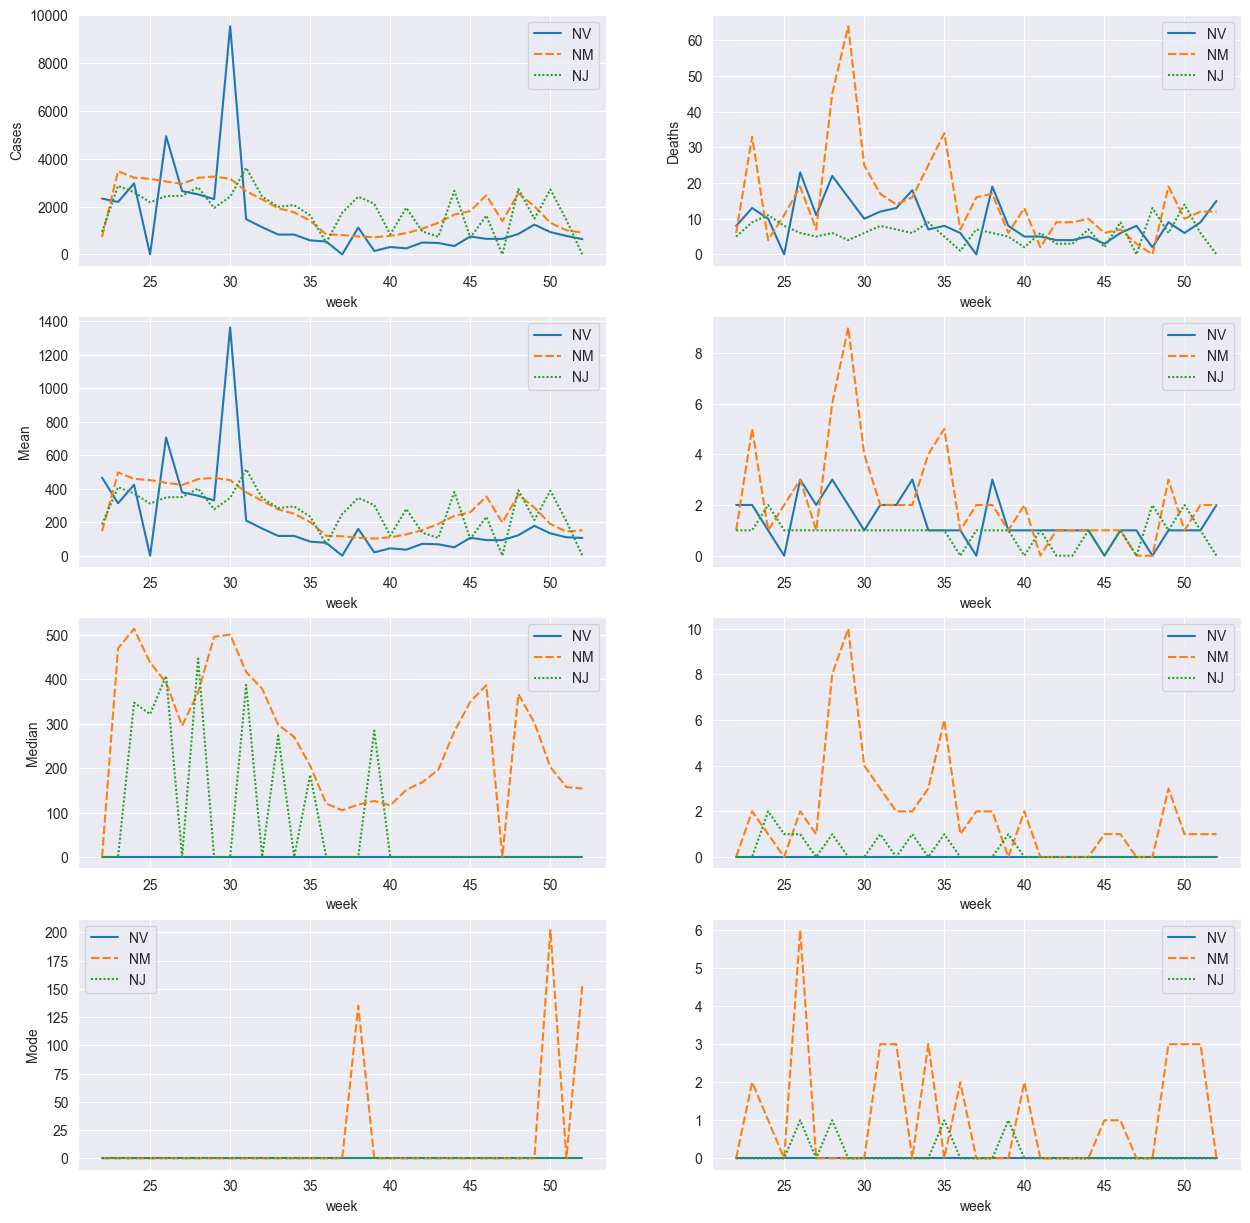

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))

ax[0,0].set_ylabel('Cases')
ax[0,1].set_ylabel('Deaths')
ax[1,0].set_ylabel('Mean')
ax[2,0].set_ylabel('Median')
ax[3,0].set_ylabel('Mode')
sns.lineplot(data=states_covid_cases_time_series_weekly_sum_df, ax=ax[0,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_sum_df, ax=ax[0,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_mean_df, ax=ax[1,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_mean_df, ax=ax[1,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_median_df, ax=ax[2,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_median_df, ax=ax[2,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_mode_df, ax=ax[3,0])
plot = sns.lineplot(data=states_covid_deaths_time_series_weekly_mode_df, ax=ax[3,1])

Now to check the US pattern and compare it to the states discussed above.

Again, this is the part where I wrangle the dataframe and prepare it for the plotting

In [11]:
us_covid_time_series_df = get_us_new_cases_and_deaths()
us_weekly_covid_sum = get_weekly_statistics(us_covid_time_series_df, 'sum')
us_weekly_covid_mean = get_weekly_statistics(us_covid_time_series_df, 'mean').round()
us_weekly_covid_median = get_weekly_statistics(us_covid_time_series_df, 'median').round()
us_weekly_covid_mode = get_weekly_statistics(us_covid_time_series_df, 'mode').round()

Plotting is done like the previous grid, column 1 is for new cases, column 2 is for new deaths, we are using the same normalization factor of 1000000, and the statistics are laid down as Mean, Median, Mode, on rows 1, 2, and 3 respectively.

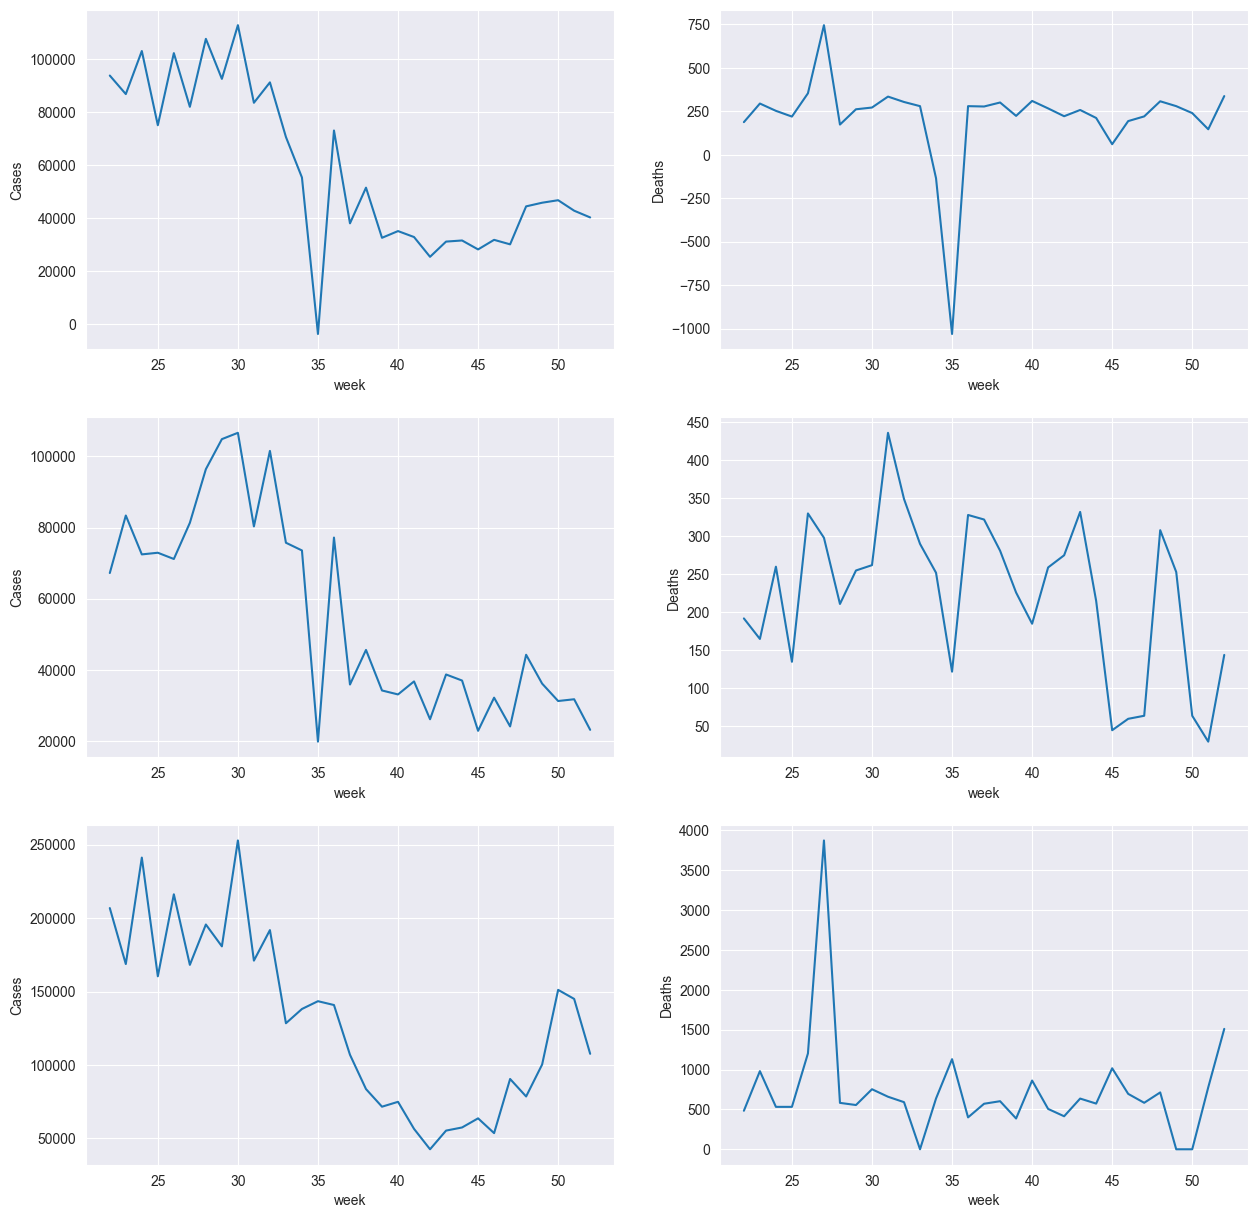

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.lineplot(data=us_weekly_covid_mean['Cases'], ax=ax[0,0])
sns.lineplot(data=us_weekly_covid_mean['Deaths'], ax=ax[0,1])
sns.lineplot(data=us_weekly_covid_median['Cases'], ax=ax[1,0])
sns.lineplot(data=us_weekly_covid_median['Deaths'], ax=ax[1,1])
sns.lineplot(data=us_weekly_covid_mode['Cases'], ax=ax[2,0])
plot = sns.lineplot(data=us_weekly_covid_mode['Deaths'], ax=ax[2,1])


#### Analysis

It can be seen that there is a surge in new cases between weeks 25 and 30, along all the states, and also it can be noticed on the US pattern; however, the rates are substantially different between the states.

We can notice a huge spike in New Mexico death rate between weeks 25 and 30, while the other states remain relatively low on deaths.

On the other hand we can see that for California, the new cases rate remains relatively high for the most of the time period discussed, except for a middle period of 10 weeks where the rates are relatively lower.

#### Conclusion

Overall conclusion of the covid situation in the US and in the mentioned states is:

* Cases and Deaths rates were high during the first half of the analysis period, the second half is relatively low in both cases and deaths, this applies on both the mentioned states and the US as a whole

* California had a huge spike of new cases during the first 10 weeks of the analysis period, the rates decreased during the following weeks, however the rate of decreasing wasn't as fast as the other states, nor was it as fast as the overall trend of the US, however it didn't come back up that much after decreasing.

* For New Mexico, we had a huge spike of deaths during the weeks 25~30, which was substantially higher than the rest of the states mentioned in the analysis.

* Similarily, for Nevada during week number 30 of the year 2022, a tremendous spike of new cases was raised, which was not seen in the other states.

#### Third Requirement

##### Identify 3 counties within a state of your choice with high cases and death rates.

The states used was California, but this can be changed by changing the STATES list in the constants section at the beginning of this notebook.

First the data was wrangled and transformed to a cleaner form, and new cases and deaths rates were calculated for every county in California, the results were sorted descendingally and the first three results were taken as the counties of interest.

In [13]:
covid_state_1_cases_df = pd.read_csv(CONFIRMED_CASES_DATASET_PATH)
covid_state_1_deaths_df = pd.read_csv(DEATHS_DATASET_PATH)
covid_state_1_cases_df = covid_state_1_cases_df[covid_state_1_cases_df['countyFIPS'] != 0]
covid_state_1_deaths_df = covid_state_1_deaths_df[covid_state_1_deaths_df['countyFIPS'] != 0]
covid_state_1_cases_df = covid_state_1_cases_df.drop_duplicates()
covid_state_1_deaths_df = covid_state_1_deaths_df.drop_duplicates()
covid_state_1_cases_df = covid_state_1_cases_df[covid_state_1_cases_df['State'] == STATES[0]]
covid_state_1_deaths_df = covid_state_1_deaths_df[covid_state_1_deaths_df['State'] == STATES[0]]
covid_state_1_counties_cases_df = covid_state_1_cases_df.drop(['County Name', 'State', 'StateFIPS'], axis=1)
covid_state_1_counties_deaths_df = covid_state_1_deaths_df.drop(['County Name', 'State', 'StateFIPS'], axis=1)
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.set_index('countyFIPS')
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.set_index('countyFIPS')
covid_state_1_counties_cases_df.columns = pd.to_datetime(covid_state_1_counties_cases_df.columns)
covid_state_1_counties_deaths_df.columns = pd.to_datetime(covid_state_1_counties_deaths_df.columns)
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.T
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.T
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df[covid_state_1_counties_cases_df.index.to_series().between(LOWER_INTERVAL_BOUND, UPPER_INTERVAL_BOUND)]
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df[covid_state_1_counties_deaths_df.index.to_series().between(LOWER_INTERVAL_BOUND, UPPER_INTERVAL_BOUND)]
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.diff().drop(LOWER_INTERVAL_BOUND)
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.diff().drop(LOWER_INTERVAL_BOUND)
covid_state_1_counties_cases_weekly_df = covid_state_1_counties_cases_df.groupby(covid_state_1_counties_cases_df.index.isocalendar().week).mean().round()
covid_state_1_counties_deaths_weekly_df = covid_state_1_counties_deaths_df.groupby(covid_state_1_counties_deaths_df.index.isocalendar().week).mean().round()
covid_state_1_counties_cases_weekly_sum_df = covid_state_1_counties_cases_weekly_df.agg(np.sum, axis=0)
covid_state_1_counties_deaths_weekly_sum_df = covid_state_1_counties_deaths_weekly_df.agg(np.sum, axis=0)
covid_state_1_counties_cases_weekly_max = covid_state_1_counties_cases_weekly_sum_df.sort_values(ascending=False).iloc[:3]
covid_state_1_counties_deaths_weekly_max = covid_state_1_counties_deaths_weekly_sum_df.sort_values(ascending=False).iloc[:3]
covid_state_1_counties_cases_weekly_max = [fips for fips in covid_state_1_counties_cases_weekly_max.index]
covid_state_1_counties_deaths_weekly_max = [fips for fips in covid_state_1_counties_deaths_weekly_max.index]

In [14]:
covid_counties_oi_cases_df = covid_state_1_counties_cases_df
covid_counties_oi_cases_df.columns = covid_counties_oi_cases_df.columns.to_list()
covid_counties_oi_cases_df = covid_counties_oi_cases_df[covid_state_1_counties_cases_weekly_max]
covid_counties_oi_cases_weekly_df = covid_counties_oi_cases_df.groupby(covid_counties_oi_cases_df.index.isocalendar().week).sum()
cases_county_names = [get_county_name_by_fips(name) for name in covid_state_1_counties_cases_weekly_max]
deaths_county_names = [get_county_name_by_fips(name) for name in covid_state_1_counties_deaths_weekly_max]
covid_counties_oi_cases_weekly_df.columns = cases_county_names
covid_counties_oi_deaths_df = covid_state_1_counties_deaths_df
covid_counties_oi_deaths_df.columns = covid_counties_oi_deaths_df.columns.to_list()
covid_counties_oi_deaths_df = covid_counties_oi_deaths_df[covid_state_1_counties_deaths_weekly_max]
covid_counties_oi_deaths_weekly_df = covid_counties_oi_deaths_df.groupby(covid_counties_oi_deaths_df.index.isocalendar().week).sum()
covid_counties_oi_deaths_weekly_df.columns = deaths_county_names

##### Counties Names

In [15]:
print("|\t\tMost Cases\t\t|\t\tMost Deaths\t\t|\n---------------------------------------------------------------------------------\n|\t\t{}\t|\t\t{}\t|\n|\t\t{}\t|\t\t{}\t\t|\n|\t\t{}\t\t|\t\t{}\t|".format(cases_county_names[0],deaths_county_names[0],cases_county_names[1],deaths_county_names[1],cases_county_names[2],deaths_county_names[2]))

|		Most Cases		|		Most Deaths		|
---------------------------------------------------------------------------------
|		Los Angeles County	|		Los Angeles County	|
|		San Diego County	|		Orange County		|
|		Orange County		|		San Bernardino County	|


#### Fourth Requirement

##### Plot weekly trends (new cases and deaths) for the top 3 infected counties. Show plots by raw values and log normalized values. Describe what is causing them and what were the peaks. Do the counties follow state pattern.

Plotting Raw Values

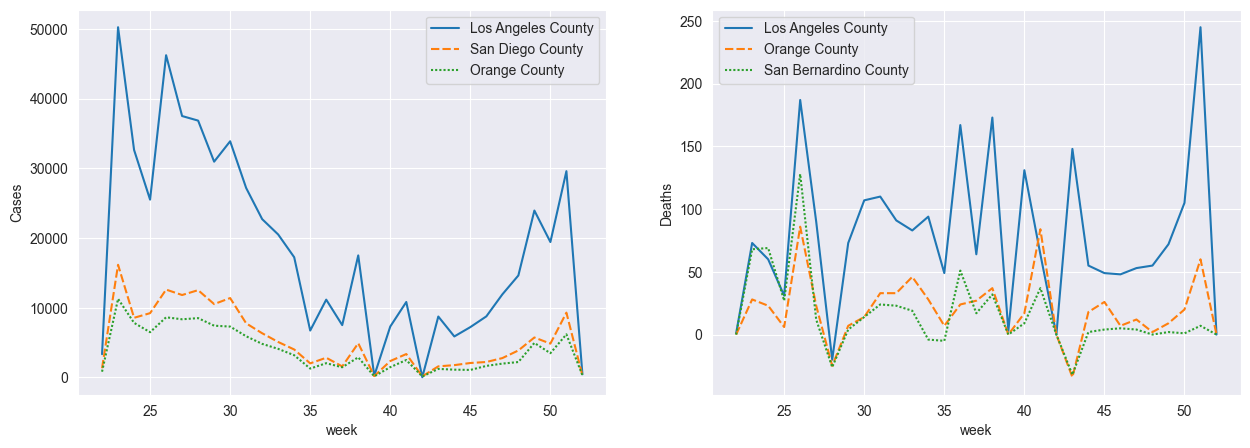

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_ylabel('Cases')
ax[1].set_ylabel('Deaths')
cases_plot = sns.lineplot(data=covid_counties_oi_cases_weekly_df, ax=ax[0])
deaths_plot = sns.lineplot(data=covid_counties_oi_deaths_weekly_df, ax=ax[1])

Normalizing the data according to each county population respectively

In [17]:
covid_counties_oi_cases_weekly_df[cases_county_names[0]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[0]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[0])).round()
covid_counties_oi_cases_weekly_df[cases_county_names[1]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[1]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[1])).round()
covid_counties_oi_cases_weekly_df[cases_county_names[2]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[2]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[2])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[0]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[0]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[0])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[1]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[1]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[1])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[2]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[2]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[2])).round()

Deaths Dataframe contains a lot of negative values, will drop these values for the log normalization

In [18]:
covid_counties_oi_deaths_weekly_df = covid_counties_oi_deaths_weekly_df[covid_counties_oi_deaths_weekly_df[covid_counties_oi_deaths_weekly_df.columns] > 0]

Plotting Log Scale

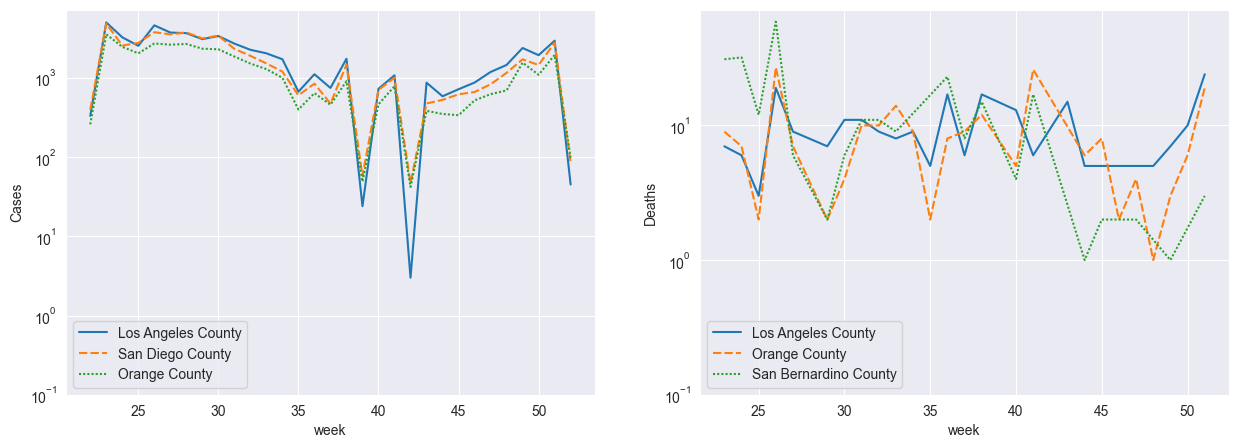

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_ylabel('Cases')
ax[1].set_ylabel('Deaths')
cases_plot = sns.lineplot(data=covid_counties_oi_cases_weekly_df, ax=ax[0])
deaths_plot = sns.lineplot(data=covid_counties_oi_deaths_weekly_df, ax=ax[1])
cases_plot = cases_plot.set(yscale='log', ybound=0.1)
deaths_plot = deaths_plot.set(yscale='log', ybound=0.1)

#### Conclusion

We have two counties common in both the rate of newly confirmed cases and deaths, those are Los Angeles, and Orange County. While the third county differ in both the new cases and the deaths, those are San Diego County and San Bernardino County respectively.

to summarize the conclusion for the analysis done on the counties of interest:

* The three counties chosen follow a similar trend when it comes to new confirmed cases; however, they are relatively different when it comes to death rates.

* We can see a spike in death rate in the San Bernardino County between the weeks 25 and 27, which when compared to the overall state trend, we can see that it follows its state trend.

* Los Angeles County remains the highest consistently in the confirmed new cases rate.

* Orange County remains the lowest consistently in the confirmed new cases rate.

* Other than the spike happening between week 25 and 27 in deaths in San Bernardino County, the county remains consistently lower in death rate in the following weeks.

